### Attempting to compute Fisher matrix

#### First: calculate derivative
### $\frac{\partial\chi}{\partial\Omega_m} \simeq \frac{\chi(\Omega_m^+)-\chi(\Omega_m^-)}{2\Delta\Omega_m}$

In [12]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}-*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
# cosm = 'Om_m'
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['Om_m','Om_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='Om_m':
        mean_Om_m, covariance_Om_m, inverse_covariance_Om_m, corrm_Om_m = compute_mean_cov(np.array(chis))
    if cosm=='Om_p':
        mean_Om_p, covariance_Om_p, inverse_covariance_Om_p, corrm_Om_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))


dChi_dOm = (mean_Om_p-mean_Om_m)/(2*0.02)
print(dChi_dOm)

Om_m 330
Om_p 330
fiducial 2994
[0.0515562  0.05912304 0.06133723 0.0655631  0.07530903 0.08141702
 0.08704038 0.09506414 0.09953977 0.10511155 0.11104656 0.1168406
 0.12227514]


#### Fisher forecast for $\Omega_m$
#### $F_{\Omega_m}=\frac{\partial\chi}{d\Omega_m}C^{-1}\frac{\partial\chi^T}{d\Omega_m}$
#### $\sigma_{\Omega_m}=\sqrt{F_{\Omega_m}^{-1}}$

In [13]:
covfactor = (2994-1)/(2994-13+6-1)
f_Om = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOm.T
sigma_Om = np.sqrt(1/f_Om)

print(sigma_Om)

0.011882718653648056


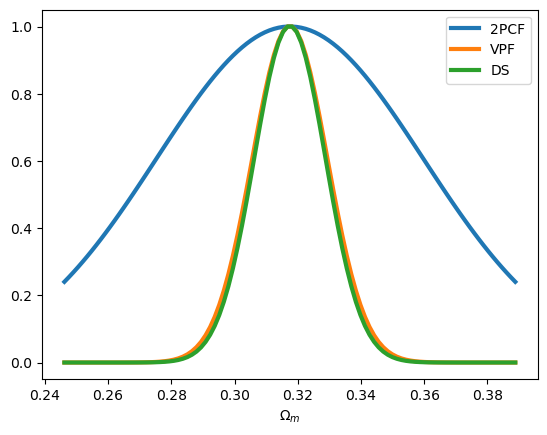

In [14]:
def gaussian(x,mu,sigma,norm=True):
    g = np.exp(-(x - mu)**2 / (2 * sigma**2))
    if norm==True:
        g /= g.max()
    return g

import matplotlib.pyplot as plt
import numpy as np

lw = 3
mu_Om = 0.3175
x = np.linspace(mu_Om - 6*sigma_Om, mu_Om + 6*sigma_Om, 100)
plt.plot(x, gaussian(x, mu_Om, 0.04221), label='2PCF', lw=lw)
plt.plot(x, gaussian(x, mu_Om, sigma_Om), label='VPF', lw=lw)
plt.plot(x, gaussian(x, mu_Om, 0.01128), label='DS', lw=lw)
plt.xlabel(r'$\Omega_m$')
plt.legend()
plt.show()